In [1]:
from simulate import HawkesProcess, PriceProcess, MultiHawkesProcess
from calibrate import HawkesCalibrator
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import pandas as pd

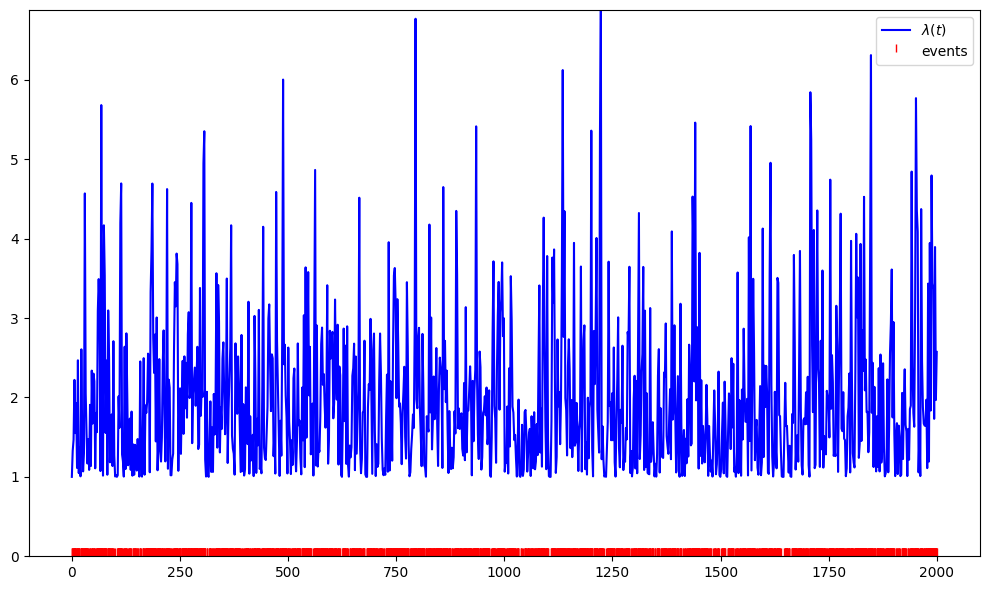

Calibration time:  0.24731159210205078 s
Estimated parameters: [0.96856243 0.92938927 1.77910912]
True parameters: (1, 1, 2)


In [28]:
mu, alpha, beta = 1, 1, 2
theta = (mu, alpha, beta)
hwk = HawkesProcess(mu, alpha, beta)
T = 2000
events = hwk.simulate(T)

hwk.plot(events, T)

cal = HawkesCalibrator(events)
theta_mle = cal.MLE(timeit=True, x0=theta, method='L-BFGS-B')
print(f'Estimated parameters: {theta_mle}')
print(f'True parameters: {theta}')

In [27]:
# turn events into time series


array([9.37932149e-01, 1.07465159e+00, 1.20054426e+00, ...,
       1.99750253e+03, 1.99775518e+03, 1.99984339e+03])

In [11]:
n_proc = 2
mus = [0.16]*n_proc
alphas = [[0.024]*n_proc for _ in range(n_proc)]
betas = [[0.11]*n_proc for _ in range(n_proc)]


T = 25000
hawkes = MultiHawkesProcess(mus, alphas, betas)
events = hawkes.simulate(T)
hawkes.plot_QQ(events)

In [ ]:
n_events = [len(events[i]) for i in range(n_proc)]
print(n_events)

[2965, 2958]


In [21]:
events

array([3.15612539e+02, 3.52086244e+02, 5.61107593e+02, ...,
       4.99903496e+05, 4.99918642e+05, 4.99930219e+05])

In [ ]:
final = []
for _ in range(100):
    ts = pp.simulate(T)
    final.append(ts.iloc[-1])

In [ ]:
class MultiHawkesProcess:

    # Implements Algo 1 from https://www.math.fsu.edu/~ychen/research/multiHawkes.pdf

    def __init__(self, mus, alphas, betas) -> None:
        self.M = len(mus) # number of dimensions
        self.mus = mus
        self.alphas = alphas
        self.betas = betas

    def get_rate(self, m, events, t):
        res = self.mus[m]
        for n in range(self.M):
            # for t_i in events[n]:
            #     if t_i < t:
            #         res += self.alphas[m][n] * np.exp(-self.betas[m][n] * (t - t_i))

            # numpy is faster
            # res += self.alphas[m][n] * (np.exp(-self.betas[m][n] * (t - events[n])) * (t > events[n])).sum()
            res += self.alphas[m][n] * np.sum(np.exp(-self.betas[m][n] * (t - events[n])) * (t >= events[n]))
        return res
    
    def get_rate_sum(self, events, t):
        return sum([self.get_rate(m, events, t) for m in range(self.M)])

    def simulate(self, T):
        s = 0
        events = [np.array([]) for _ in range(self.M)]

        while s < T:
            lambda_bar = self.get_rate_sum(events, s) # we can be smarter here cf. page 43 de http://lamp.ecp.fr/MAS/fiQuant/ioane_files/HawkesCourseSlides.pdf
            w = np.random.exponential(1/lambda_bar)
            s += w
            D = np.random.rand()
            new_lambda_bar = self.get_rate_sum(events, s)
            if D*lambda_bar <= new_lambda_bar:
                k = 0
                new_sum = self.get_rate(k, events, s)
                while D*lambda_bar > new_sum:
                    k += 1
                    new_sum += self.get_rate(k, events, s)
                if s <= T:
                    # events[k].append(s) # numpy is faster
                    events[k] = np.append(events[k], s)

        return events
    
    def plot(self, events, T, n_points=1000):
        T_range = np.linspace(0, T, n_points)
        rates = [[self.get_rate(m, events, t) for t in T_range] for m in range(self.M)]
        fig, axs = plt.subplots(self.M, 1, figsize=(10, 6))
        max_rate = max([max(r) for r in rates])

        for i in range(self.M):
            ax = axs[i]
            ax.plot(T_range, rates[i], label=f'$\\lambda_{i}(t)$', c='blue')
            ax.plot(events[i], [0]*len(events[i]), marker=2, ls='', label=f'events {i}', c='red')
            ax.legend()
            ax.set_ylim(0, max_rate)

        plt.tight_layout()
        plt.show()

In [ ]:
n_proc = 2
mus = [0.16]*n_proc
alphas = [[0.024]*n_proc for _ in range(n_proc)]
betas = [[0.11]*n_proc for _ in range(n_proc)]


T = 100
hawkes = MultiHawkesProcess(mus, alphas, betas)
events = hawkes.simulate(T)
n_events = [len(e) for e in events]

all_n_events = []

N = 1000
for _ in range(N):
    events = hawkes.simulate(T)
    n_events = [len(e) for e in events]
    all_n_events.append(n_events)

mean_n_events = np.mean(all_n_events, axis=0)

In [ ]:
mean_n_events # removed the "we remove last event" part

array([26.069, 26.102])

In [ ]:
for k in range(n_proc):
    rate_avg = np.mean([hawkes.get_rate(k, events, t) for t in np.linspace(0, T, 1000)])
    print(f'Average rate for process {k}: {rate_avg}')

Average rate for process 0: 1.9852010762430596
Average rate for process 1: 1.9852010762430596
Average rate for process 2: 1.9852010762430596
Average rate for process 3: 1.9852010762430596
Average rate for process 4: 1.9852010762430596


In [ ]:
mean_n_events # 4th try

array([145.66, 145.89, 145.87, 147.37, 140.51])

In [ ]:
# mean_n_events # 3rd try

array([143.7 , 143.65, 140.76, 141.3 , 139.12])

In [ ]:
# mean_n_events # 2nd try

array([145.54, 146.09, 146.33, 147.56, 141.54])

In [ ]:
# mean_n_events # 1st try

array([136.88, 137.41, 134.76, 136.25, 130.39])

In [ ]:
mu, alpha, beta = 0.16, 0.024, 0.11
T = 500
pp = PriceProcess(mu, alpha, beta)

s = 0
N = 50

for _ in range(N):
    s += pp.simulate(T)
mean = s / N
print(f'average final price: {mean}')

average final price: 5.58


In [ ]:
# mus = [0.16, 0.16]
# alphas = [[0.024, 0.024], [0.024, 0.024]]
# betas = [[0.11, 0.11], [0.11, 0.11]]

# hawkes = MultiHawkesProcess(mus, alphas, betas)
# ts = hawkes.simulate(T)
# hawkes.get_rate(0, ts, 400)

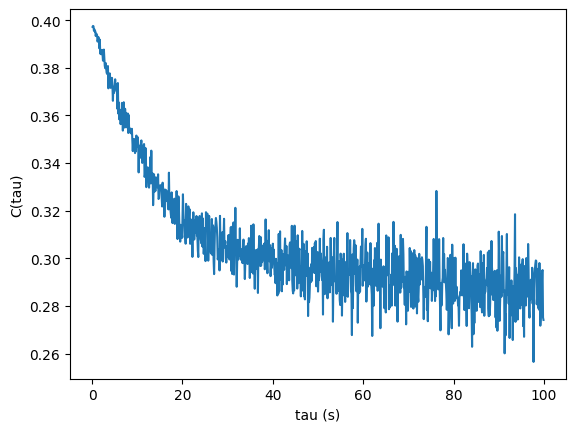

In [ ]:
def C(ts: pd.Series, tau: pd.Timedelta):
    # resample the series to have a constant time step
    T = ts.index[-1] - ts.index[0]
    ts = ts.resample(rule=tau).first().ffill()
    qv = ((ts.diff())**2).sum() / T.total_seconds()
    return qv

taus = pd.to_timedelta(range(100,100000,100), unit='ms')

C_values = [C(ts, tau) for tau in taus]
plt.plot(taus.total_seconds(), C_values)
plt.xlabel('tau (s)')
plt.ylabel('C(tau)')
plt.show()

In [ ]:
def C_func(theta):
    mu, alpha, beta = theta
    Lambda = 2*mu / (1 - alpha/beta)
    kappa = 1 / (1 + alpha/beta)
    gamma = alpha + beta

    def C(tau):
        return Lambda * ( kappa**2 + (1-kappa**2)*(1-np.exp(-gamma*tau))/(gamma*tau))
    
    return C

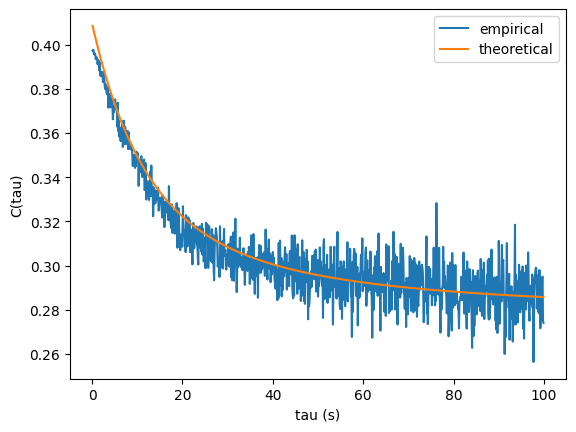

In [ ]:
C_th = C_func([mu, alpha, beta])
C_values_th = [C_th(tau.total_seconds()) for tau in taus]
plt.plot(taus.total_seconds(), C_values, label='empirical')
plt.plot(taus.total_seconds(), C_values_th, label='theoretical')
plt.xlabel('tau (s)')   
plt.ylabel('C(tau)')
plt.legend()
plt.show()

## Playing with multihawx

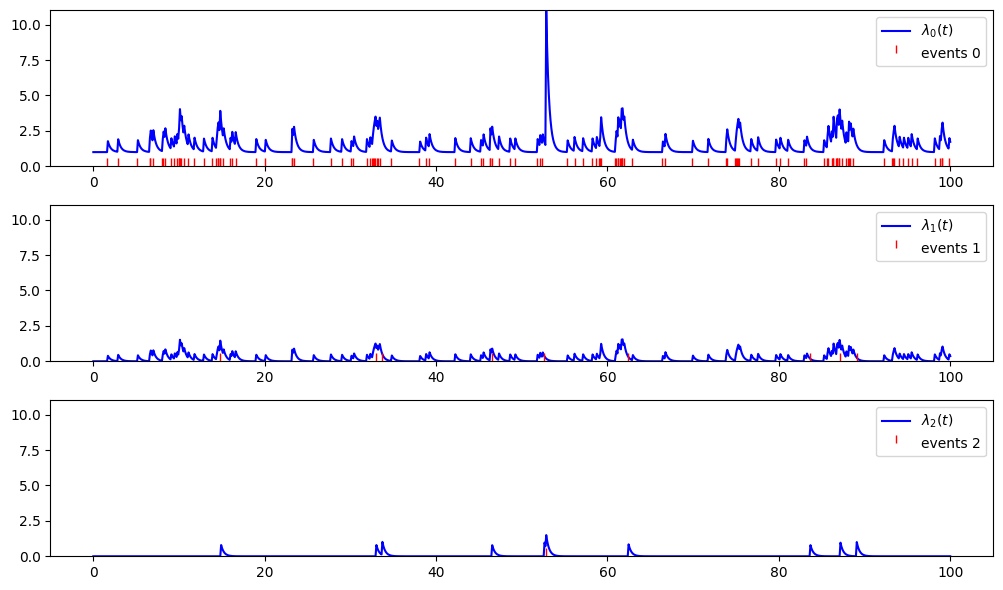

In [ ]:
mus = [1, 0, 0]
alphas = [[1, 0, 10], [0.5, 0, 0], [0, 1, 1]]
betas = [[3, 3, 3], [3, 3, 3], [3, 3, 3]]

hawkes = MultiHawkesProcess(mus, alphas, betas)
T = 100
events = hawkes.simulate(T)
hawkes.plot(events, T)

## QQ plot to perform KS residuals test to make sure my univariate hawx algo is correct

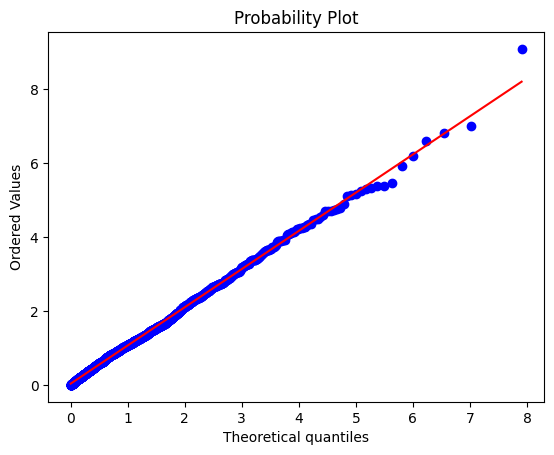

In [ ]:
mu, alpha, beta = 0.16, 0.024, 0.11
hwk = HawkesProcess(mu, alpha, beta)
T = 10000
events = hwk.simulate(T)

hwk.plot_QQ(events)

In [ ]:
# retrieve the actual EURUSD tick data

# df = pd.read_csv("../../datasets/TrueFX/EURUSD-2024-02/EURUSD-2024-02.csv", header=None)
# df.columns = ['Pair', 'TimeStamp', 'Bid', 'Ask']
# df = df[['TimeStamp', 'Bid', 'Ask']]
# df['TimeStamp'] = pd.to_datetime(df['TimeStamp']) - pd.Timedelta(hours=5) # turn GMT to EST time
# df['Date'] = df['TimeStamp'].dt.date

# chosen_date = pd.to_datetime('2024-02-01').date()
# sub_df = df[df['Date'] == chosen_date]
# sub_df
# copy_sub_df = sub_df.copy()